In [1]:
!CUDA_VISIBLE_DEVICES=1

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import pandas as pd
import random
from scipy import stats
import torch
import seaborn as sns
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from tqdm import tqdm

autoencoder

In [2]:
def load_VAE():
    autoencoder = VAE(
        num_genes=14652,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/home/workplace/cfDiffusion/checkpoint/VAE/muris_mam_spl_T_B/model_seed=0_step=800000.pt'))
    return autoencoder

real data

In [12]:
# real data in h5ad format
adata = sc.read_h5ad('/home/workplace/cfDiffusion/dataset/muris_mam_spl_T_B.h5ad')
# sc.pp.filter_genes(adata, min_cells=3)
# sc.pp.filter_cells(adata, min_genes=10)
adata.var_names_make_unique()

In [9]:
adata.obs['organ'].cat.categories

Index(['mammary', 'spleen'], dtype='object')

In [10]:
adata.obs['celltype'].cat.categories

Index(['B cell', 'T cell'], dtype='object')

In [11]:
adata.shape

(10552, 23433)

In [4]:
# real data in h5ad format
adata = sc.read_h5ad('/home/workplace/cfDiffusion/dataset/muris_mam_spl_T_B.h5ad')
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=10)
adata.var_names_make_unique()

gene_names = adata.var_names
cellclass = adata.obs['celltype']
organtype = adata.obs['organ']
celltype = [cellclass[i]+'_'+organtype[i] for i in range(len(cellclass))]
adata.obs['cellinfo'] = celltype

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

cell_data = adata.X.toarray()

cell_data.shape

AnnData object with n_obs × n_vars = 68579 × 17789
    obs: 'n_genes', 'celltype'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'

In [8]:
68579/11

6234.454545454545

generated data

In [5]:
cato = ['CD14+ Monocyte', 'CD19+ B', 'CD34+', 'CD4+ T Helper2',
       'CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T',
       'CD4+/CD45RO+ Memory', 'CD56+ NK', 'CD8+ Cytotoxic T',
       'CD8+/CD45RA+ Naive Cytotoxic', 'Dendritic']

cell_gen_all = []
gen_class = []
length_per_type = 6250

for i in range(11):
    npyfile=np.load(f'/home/workplace/cfDiffusion/generation/pbmc68k/cell{i}_cache5.npy',allow_pickle=True)
    cell_gen_all.append(npyfile[:length_per_type])
    gen_class+=[cato[i]]*length_per_type
cell_gen_all = np.concatenate(cell_gen_all, axis=0)

autoencoder = load_VAE()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

sim_adata = ad.AnnData(X=cell_gen_all)
sim_adata.obs['celltype'] = gen_class

qq plot

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 51 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'plus', 'r', 's', 'seven', 'six', 'slash', 'space', 't', 'three', 'two', 'v', 'w', 'x', 'y', 'z', 'zero']
Glyph IDs:   [0, 1, 2, 3, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 43, 46, 48, 49, 50, 52, 53, 54, 55, 68, 69, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 89, 90, 91, 92, 93]
Closed glyph list over 'GSUB': 56 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'H', 'K', 'M', 'N', 'O', 'Q', 'R', 'S', 'T', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'fi', 'five', 'fl', 'four', 'g', 'hyphen', 'i', 'l', 'm', '

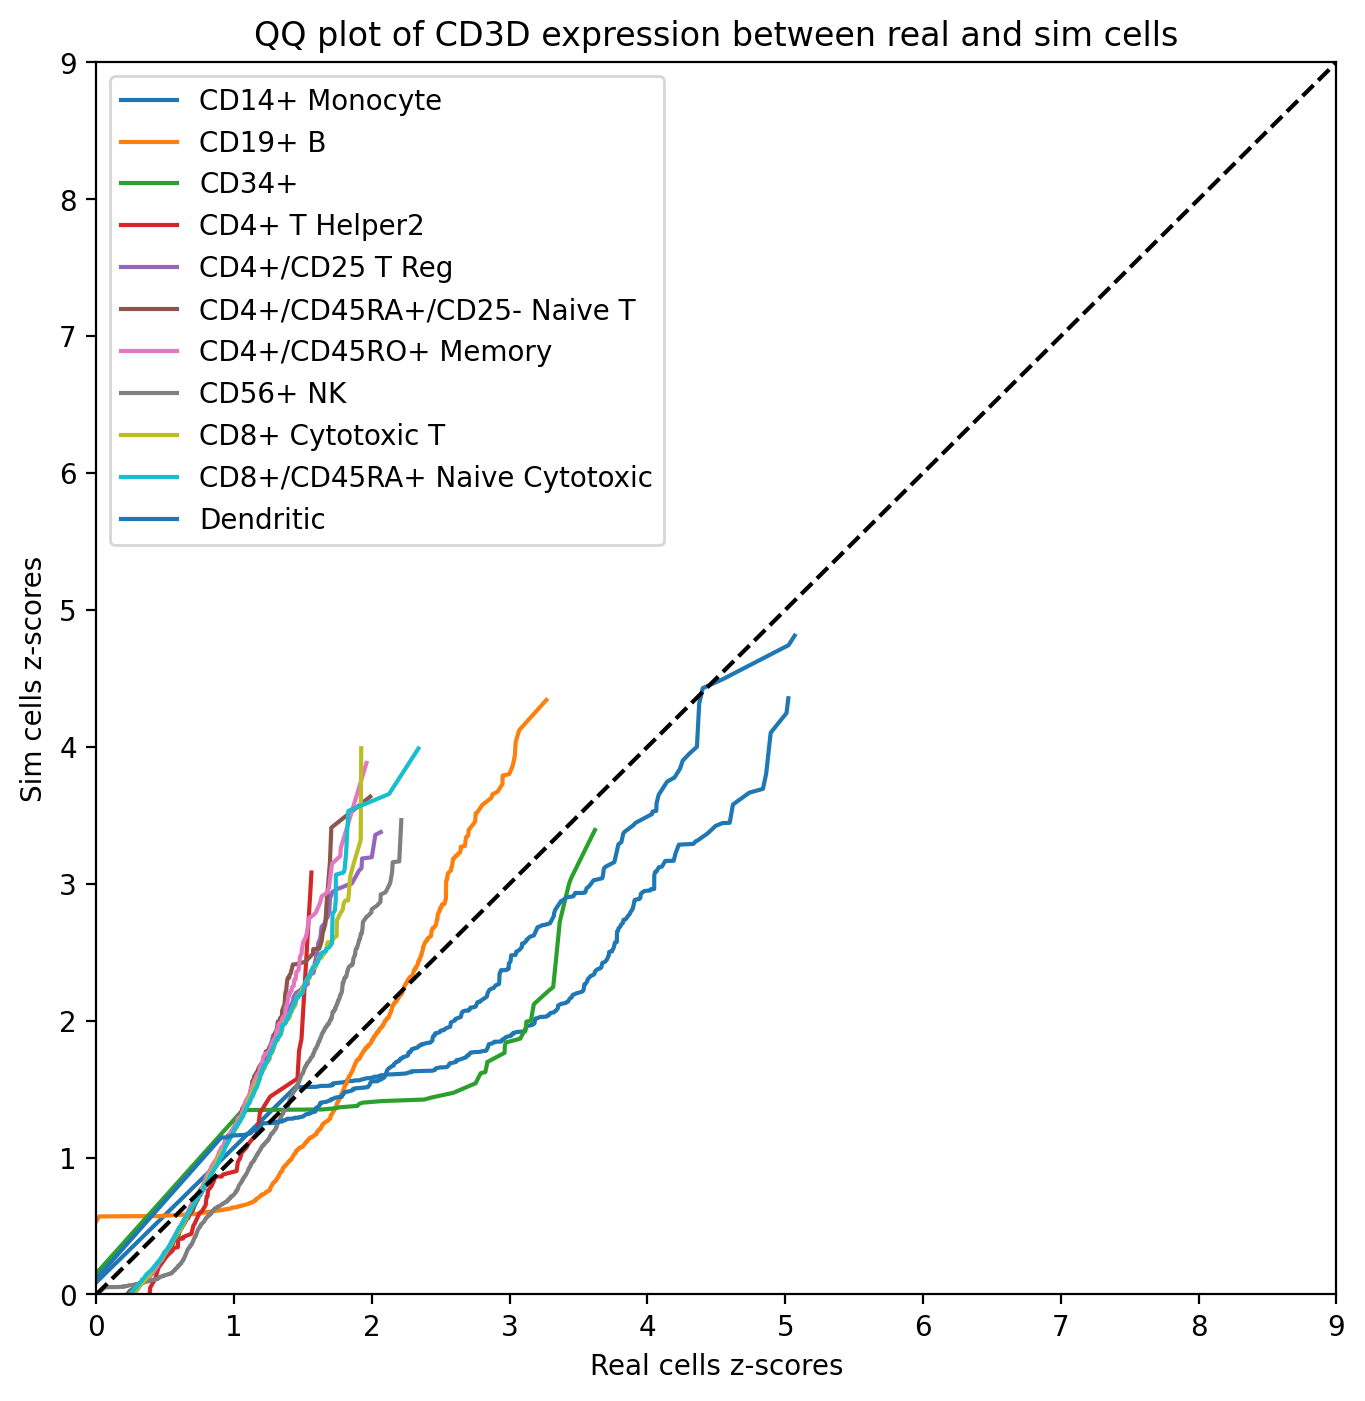

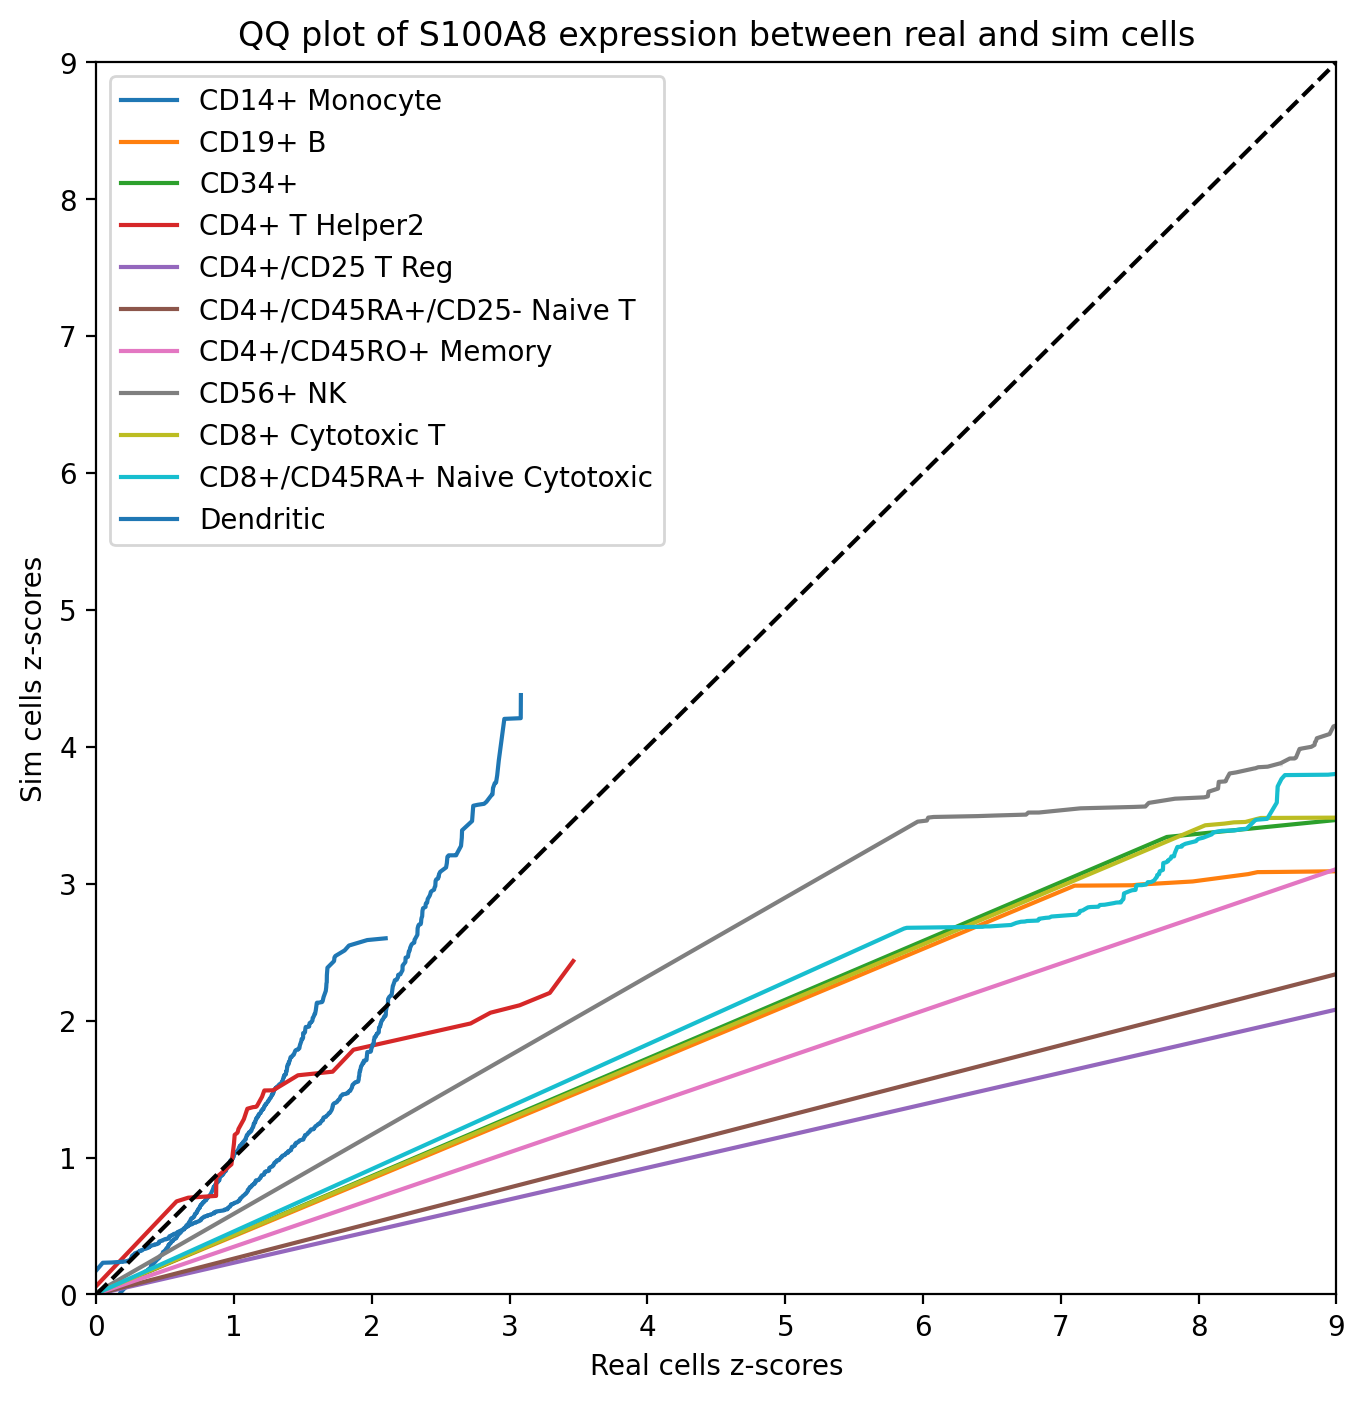

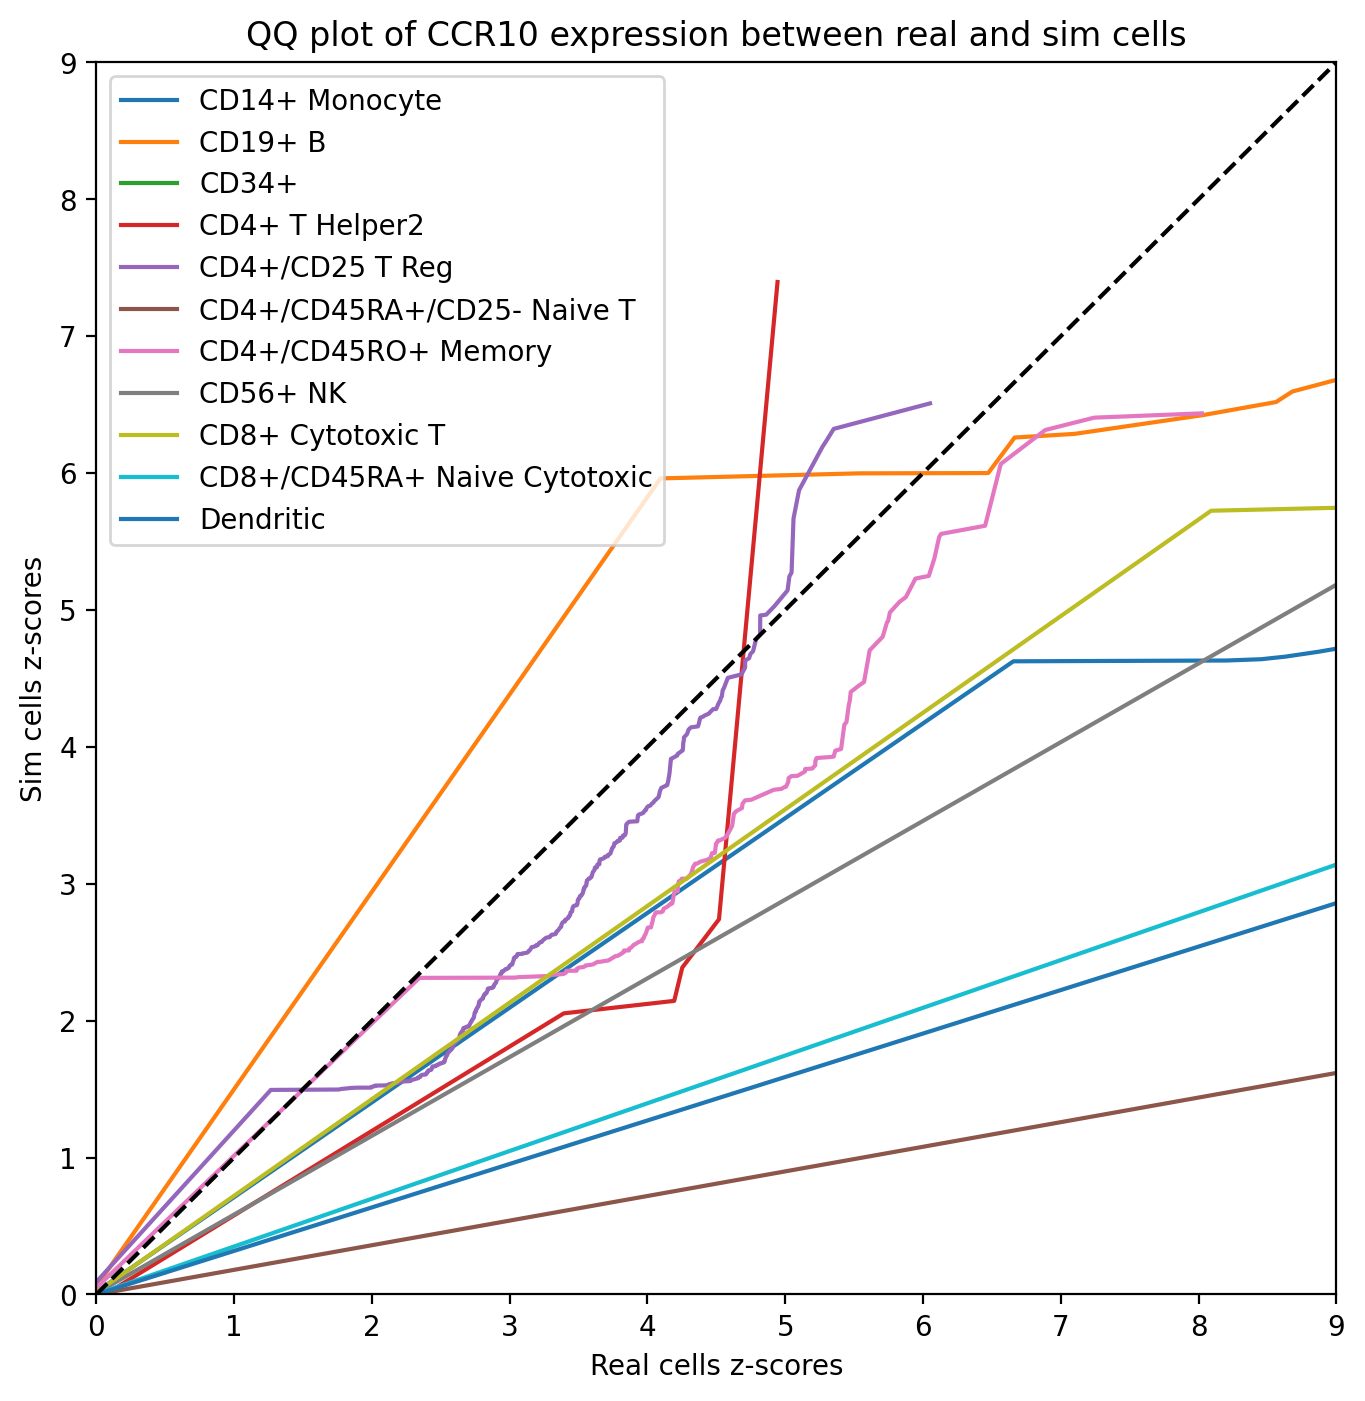

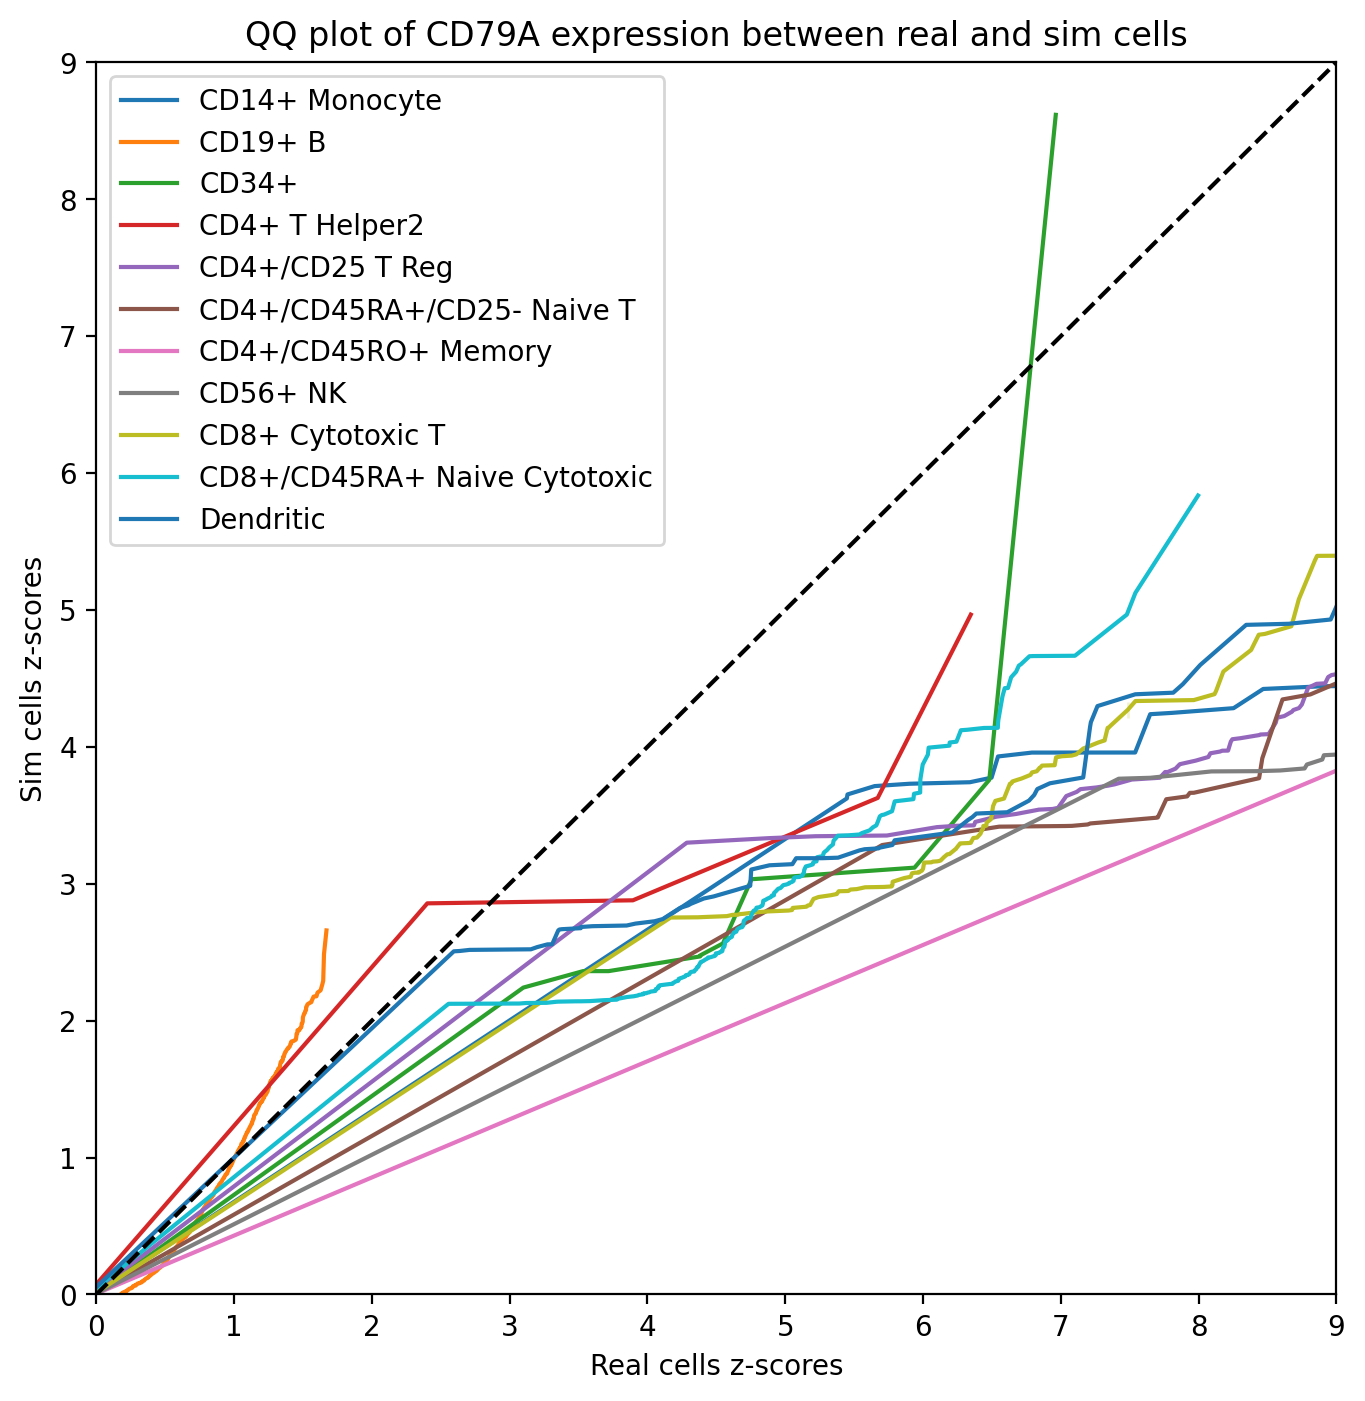

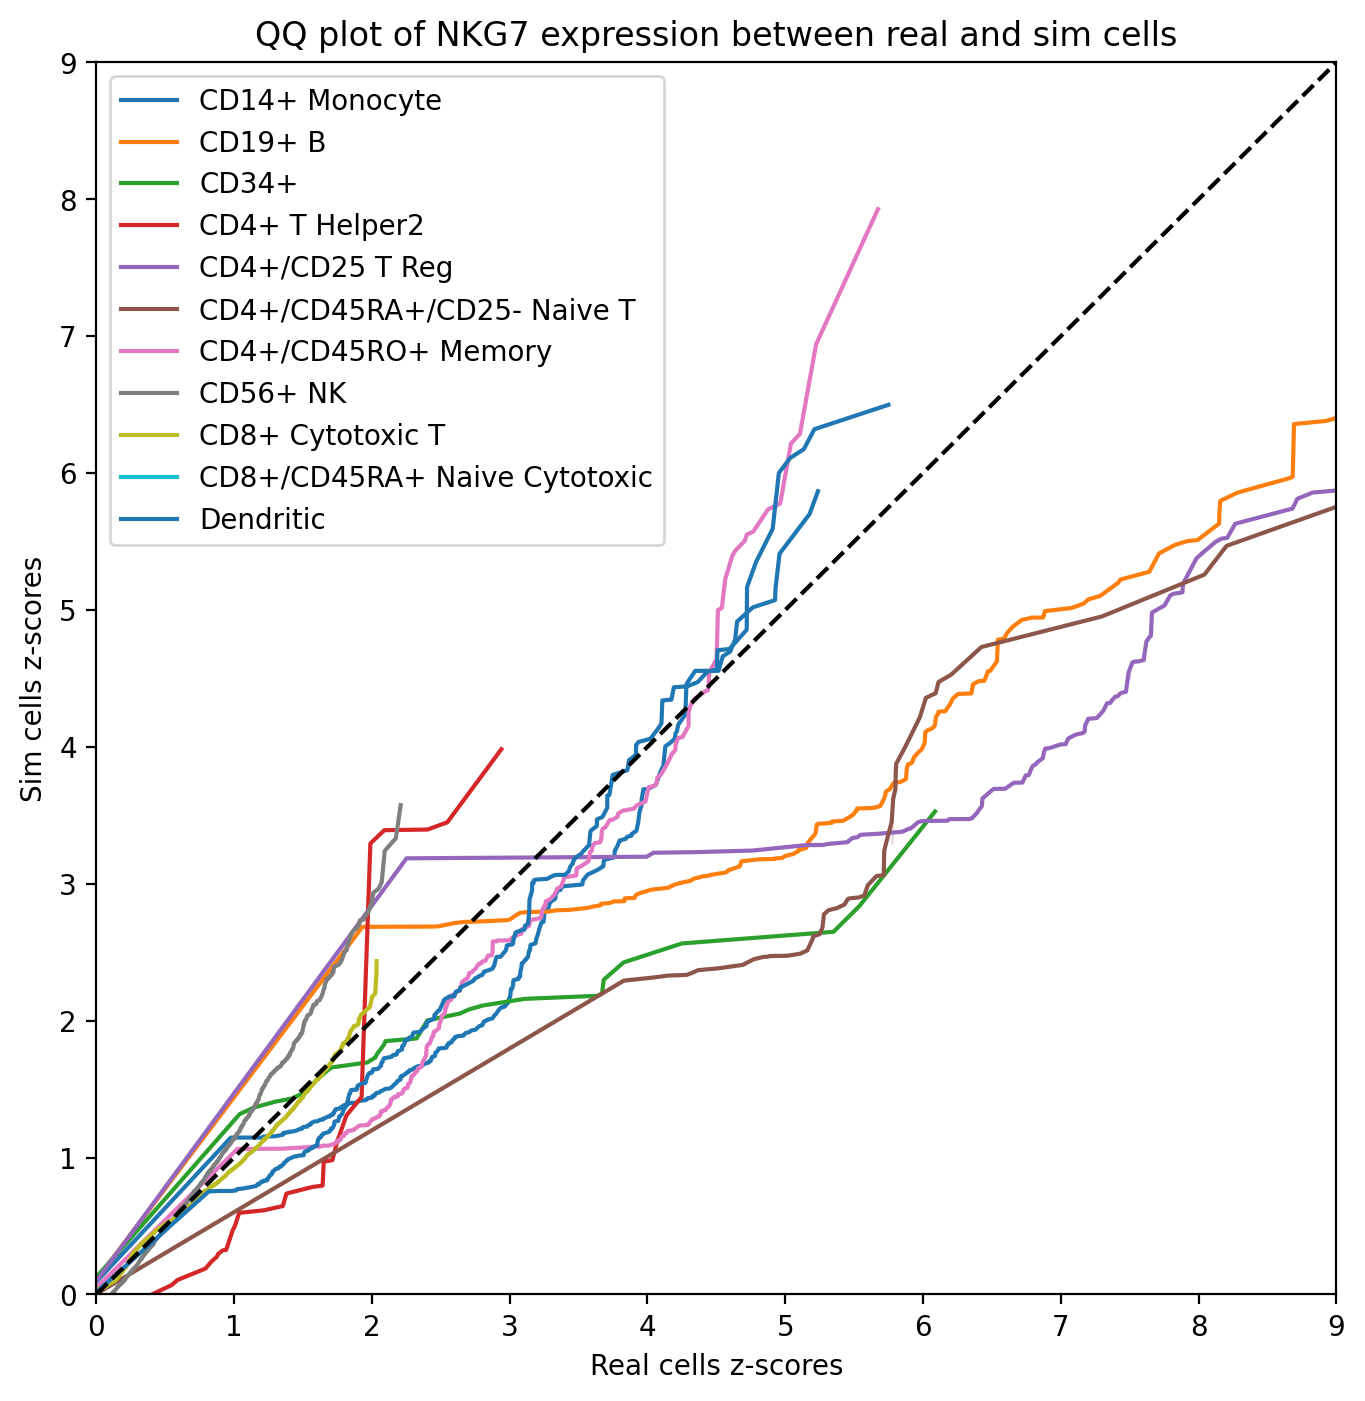

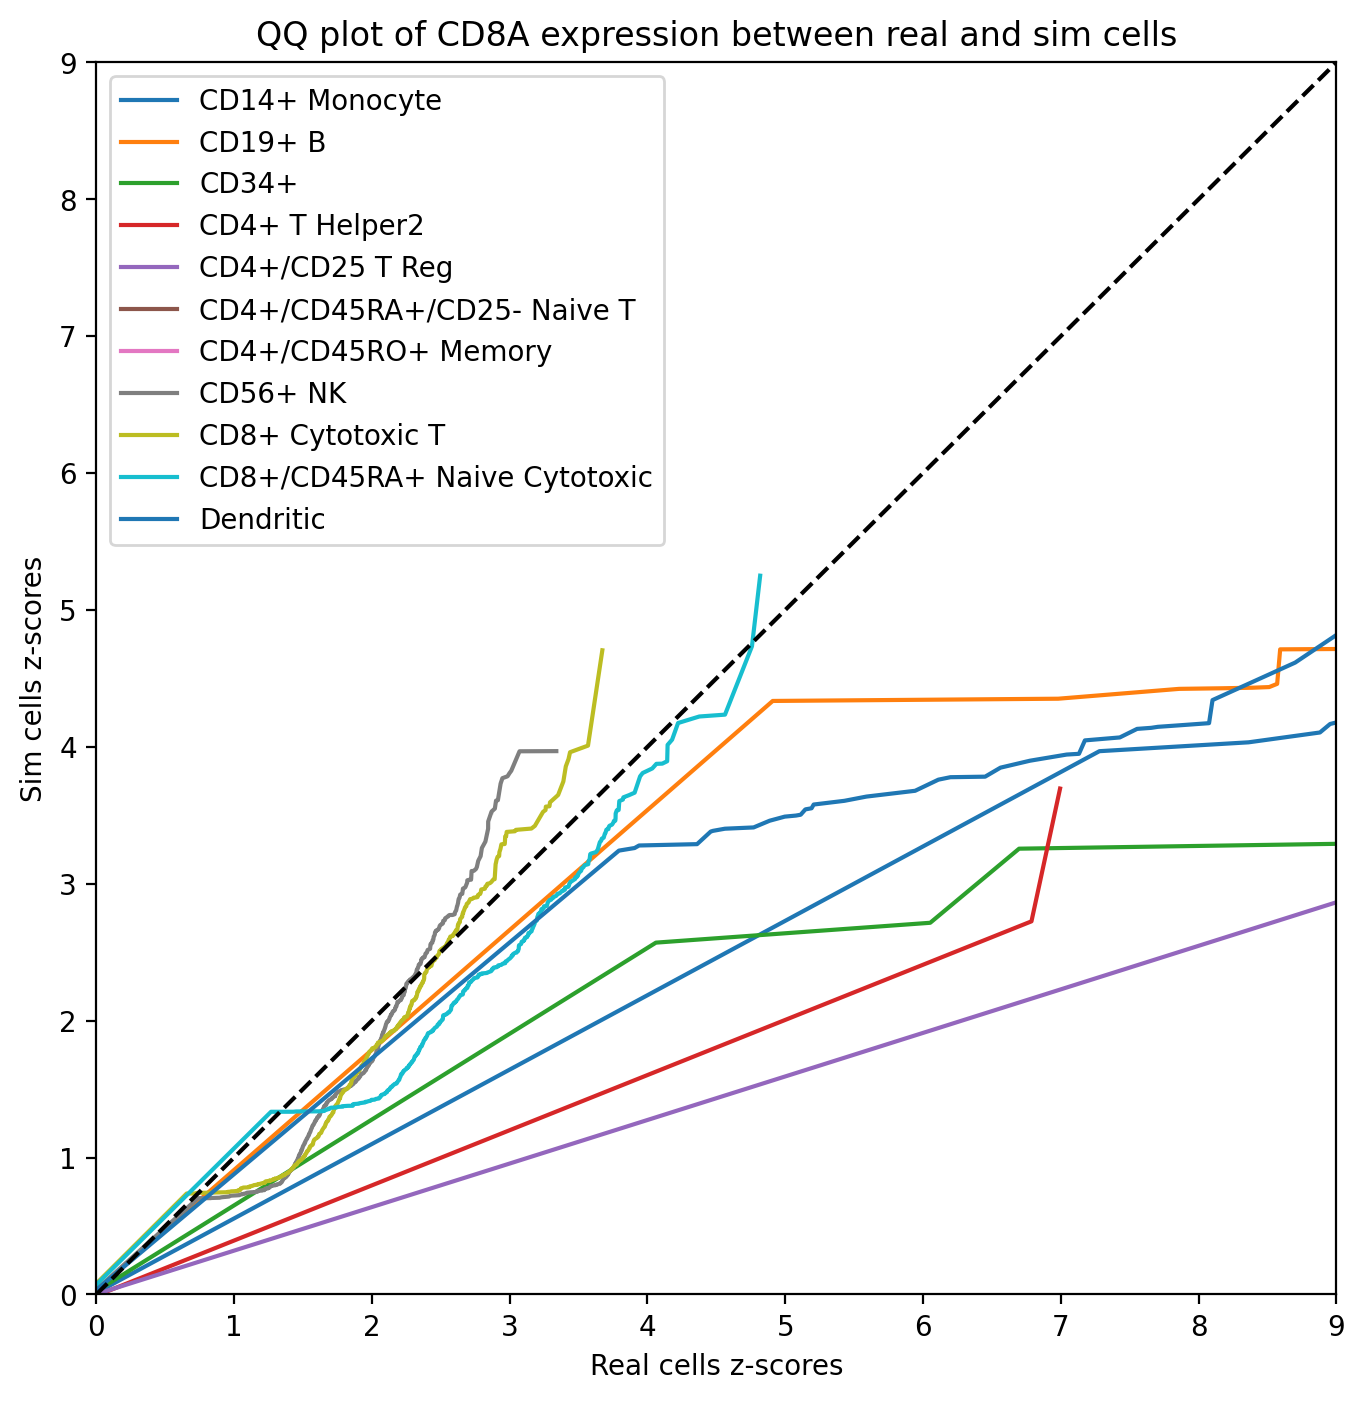

In [6]:
import scipy.stats as stats  
  
key_tf = ['CD3D','S100A8','CCR10','CD79A','NKG7','CD8A']

for i in range(len(key_tf)):
    gene_of_interest = key_tf[i]  
    gene_index = adata.var_names.tolist().index(gene_of_interest)  

    plt.figure(figsize=(8, 8))

    for type in np.unique(sim_adata.obs['celltype']):
        # 提取特定基因在 real 和 sim 类细胞中的表达  
        a = adata[adata.obs['celltype'] == type]
        b = sim_adata[sim_adata.obs['celltype'] == type]
        size = min(a.X.toarray().shape[0],b.X.toarray().shape[0])
        real_gene_expression = a[:size, gene_index].X.toarray().squeeze(-1)  
        sim_gene_expression = b[:size, gene_index].X.toarray().squeeze(-1)  
        
        # 计算特定基因在 real 和 sim 类细胞中表达的 z-score  
        real_gene_z_scores = stats.zscore(real_gene_expression)  
        sim_gene_z_scores = stats.zscore(sim_gene_expression)  
        
        # 对 z-scores 进行排序  
        real_gene_z_scores_sorted = np.sort(real_gene_z_scores)  
        sim_gene_z_scores_sorted = np.sort(sim_gene_z_scores)  
        
        # 绘制 QQ plot    
        sns.lineplot(x=real_gene_z_scores_sorted, y=sim_gene_z_scores_sorted, label=type) #,edgecolor="none" 

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.xlabel("Real cells z-scores")  
    plt.ylabel("Sim cells z-scores") 
    plt.legend(loc="upper left") #np.unique(type1),
    plt.title(f"QQ plot of {gene_of_interest} expression between real and sim cells")  
    plt.plot([0,10], [0,10], linestyle="--",color='black')  
    plt.xlim(0, 9)
    plt.ylim(0, 9)
    # plt.show()  
    plt.savefig(f'./cache5_pbmc68k_chara_gene{key_tf[i]}_QQ.pdf')

